## Solving the XOR problem with the ANNarchy-NEAT extension

In this Notebook we will use the ANNarchy-NEAT extension to generate spiking neural networks to solve the XOR problem. In XOR, we have two inputs that can each be 0 or 1, and the output is 1 only when one of the inputs is 1 (but not both). So, XOR gives the following outputs:

    0 XOR 0  = 0
    0 XOR 1  = 1
    1 XOR 0  = 1
    1 XOR 1  = 0



First we will import ANNarchy to simulate the spiking neural network.

In [1]:
%pip install ANNarchy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


We now import the additional code where the NEAT algorithms is implemented. This is taken from the repository where the code of the Baladron et al. (2025) paper is stored.

In [2]:
import requests

url = "https://github.com/bastianloyola/NEAT-ANNarchy/raw/refs/heads/main/neatannarchy.py"
file_name = "neatannarchy.py"
response = requests.get(url)

if response.status_code == 200:
    with open(file_name, "wb") as file:
        file.write(response.content)
    print(f"File succesfully downloaded and stored as '{file_name}'.")
else:
    print(f"Error while downloading the file: {response.status_code}")


File succesfully downloaded and stored as 'neatannarchy.py'.


We now import the necessary libraries including ANNarchy and the necesary scientific code.

In [3]:
from ANNarchy import *
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import scipy.sparse

ANNarchy 4.7 (4.7.3) on linux (posix).


# Neuron model
We now define the neuron model to use. We then copy the model definition to a file named neuronmodel.py.

For more information regarding how to define neuron modesl in ANNarchy go to https://annarchy.readthedocs.io/API/Neuron.html


In [4]:
%%writefile neuronmodel.py

from ANNarchy import *

IZHIKEVICH = Neuron(  #I = 20
    parameters="""
        a = 0.02 : population
        b = 0.2 : population
        c = -65.0 : population
        d = 8.0 : population
        I = 0.0
        tau_I = 10.0 : population
    """,
    equations="""
        dv/dt = 0.04*v*v + 5*v + 140 - u + I + g_exc - g_inh : init=-65
        tau_I * dg_exc/dt = -g_exc
        tau_I * dg_inh/dt = -g_inh
        du/dt = a*(b*v - u) : init=-14.0
    """,
    spike="v >= 30.0",
    reset="v = c; u += d"
)

Writing neuronmodel.py


# Fitness function

---
Next, we define the fitness function which includes the coding scheme for the input and outputs. The fitness function must return a value of the quality of the network. The NEAT algorithm will search for networks that maximize this value.



For the XOR problem we define the 4 possible input combinations and then determine the network output for each. The return value is equal to the number of input pattern with the proper output.

There are 2 input neurons, one for each input variable. If a variable is 1 then its input current (I) is set to 15. For each input pattern, the network is simulated for 10ms.


In [5]:
%%writefile fitness.py

from ANNarchy import *
from sklearn.datasets import load_wine
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import random as rd

# DATA
# Load the data from sklearn
def load_dataset(dataset_loader):
    data = dataset_loader()
    return np.array(data.data), np.array(data.target)

def normalize_data(data):
    # Normalize the data between [0, 1] using numpy
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Load the example dataset
data_X, data_y = load_dataset(load_wine)
# Normalize the data between [0, 1]
data_X_normalized = normalize_data(data_X)

# CODING
# Single-Spike encoding
def single_spike_encoding(data, num_neurons=2):
    encoded_data = []
    step = 1 / num_neurons
    for value in data:
        neuron_idx = min(int(value / step), num_neurons - 1)
        spike_train = [0] * num_neurons
        spike_train[neuron_idx] = 1
        encoded_data.append(spike_train)
    return np.array(encoded_data)

# DECODING
# Voting decoding
def vote_decoding(spikes, n_input, n_output):
    votes = []
    total = n_input + n_output
    for i in range(n_input,total):
        votes.append(len(spikes[i]))
    max_spikes = max(votes)
    index_max = [i for i, x in enumerate(votes) if x == max_spikes]
    
    
    if len(index_max) == 1:
        index = index_max[0]
    else:
        index = rd.choice(index_max)

    return index

# SIMULATION
def simulate_single_spike(data, n_input, neurons_per_input, pop, time=10.0, flag = False):
    simulate(5.0)
    sample = single_spike_encoding(data, neurons_per_input)
    if flag: print("sample: ",sample)
    # For each sample
    if neurons_per_input != 1:
        n = neurons_per_input
        for k in range(n_input):
            if sample[k//n][k%n] == 1:
                pop[k].v = -40.0
            if flag: print("pop[k].v: ",pop[k].v)
    else:
        for k in range(n_input):
            pop[k].v = -40.0 if sample[k] == 1 else 0.0 
    simulate(time)

def bootstrap_data(data_x, data_y,n_bootstrap, n_samples):
    # List to save the generated datasets
    bootstrap_datasets = []
    # Generate the datasets using bootstrapping
    for i in range(n_bootstrap):
        X_bootstrap, y_bootstrap = resample(data_x, data_y, replace=True, n_samples=n_samples)
        bootstrap_datasets.append((X_bootstrap, y_bootstrap))
    return bootstrap_datasets
  
def fitness(pop, M, input_index, output_index, inputWeights, genome_id ,flag=False):
    print("genome_id: ", genome_id)
    n_input = len(input_index)
    n_output = len(output_index)
    subsets = bootstrap_data(data_X_normalized, data_y,50,50)
    print(1)
    total = 0
    n = len(subsets)
    print(2)
    for i in range(n):
        x = subsets[i][0]
        y = subsets[i][1]

        sum = 0
        samples = len(x)
        for j in range(samples):
            neuronas_por_input = 5
            target = y[j]
            simulate_single_spike(x[j], n_input, neuronas_por_input, pop, 10.0, flag)
            spikes = M.get('spike')

            index = vote_decoding(spikes, n_input, n_output)
            if index == target:
                    sum += 1.0

            pop.reset()
            M.reset()
        total += (sum/samples)
    fitness = round(total/n,2)
    print("    fitness: ", fitness)
    return fitness

Writing fitness.py


# Hyperparameters

We will now create a folder where we will store all the required configuration files.\

In [6]:
%mkdir -p config

Each configuration file must define the following parameters:

- keep: percentage of the population that will remain after the elimination process
- threshold: Threshold for the difference between an individual and the representative of a species to incorporate them into a species
- interSpecieRate: probabilidad de generar un entrecruzamiento entre individuos de distintas especies
- noCrossoverOff: probability of a crossover between individuals of different species.
- probabilityWeightMutated: Probability that a weight is perturbed.
- probabilityAddNodeSmall: Probability that a node is created for a small network
- probabilityAddLink_small: Probability that a connection is created for a small network
- probabilityAddNodeLarge: Probability that a node is created for a large network
- probabilityAddLink_Large: Probability that a connection is created for a large network
- c1, c2 y c3: Factors used during the speciation
- largeSize: Number of neurons needed to consider a network as large
- numberInputs: Number of input neurons
- numberOutputs: Number of output neurons
- n_max: Maximum number of neurons a network
- learningRate: Maximum value of a weight perturbation
- inputWeights: Values used to modulate the input values while computing the fitness.
- weightsRange: Initial possible range of values for the initial random weights(n < m).

In [7]:
%%writefile config/config.cfg
keep=0.412
threshold=3.039
interSpeciesRate=0.001
noCrossoverOff=0.244
probabilityWeightMutated=0.797
probabilityAddNodeSmall=0.022
probabilityAddLink_small=0.042
probabilityAddNodeLarge=0.182
probabilityAddLink_Large=0.151
c1=1.289
c2=1.113
c3=0.364
largeSize=20
numberInputs=65
numberOutputs=3
n_max=300
learningRate=5
inputWeights=110,150
weightsRange=-10,10

Writing config/config.cfg


We still need to define a few more parameters.

- func: Name of the fitness function
- neuron_model: Name of the neuron model
- process: Amount of parallel processes used while computing the fitness values.
- evolutions: Amount of iterations of the NEAT main loop
- population: Amount of genomes

In [8]:
func = "fitness"
neuron_model = "IZHIKEVICH"
process = 10
evolutions = 50
population = 50
trial = 1

Finally we execute NEAT and obtain the fitness of the best network found.

In [9]:
from neatannarchy import runNEAT, fitness_value, plot_information

In [10]:
runNEAT(trial, func, neuron_model, process, evolutions, population)

In [11]:
print("Fitness value: ", fitness_value(trial))

Fitness value:  0.98


Data saved in results/trial-1/output.json


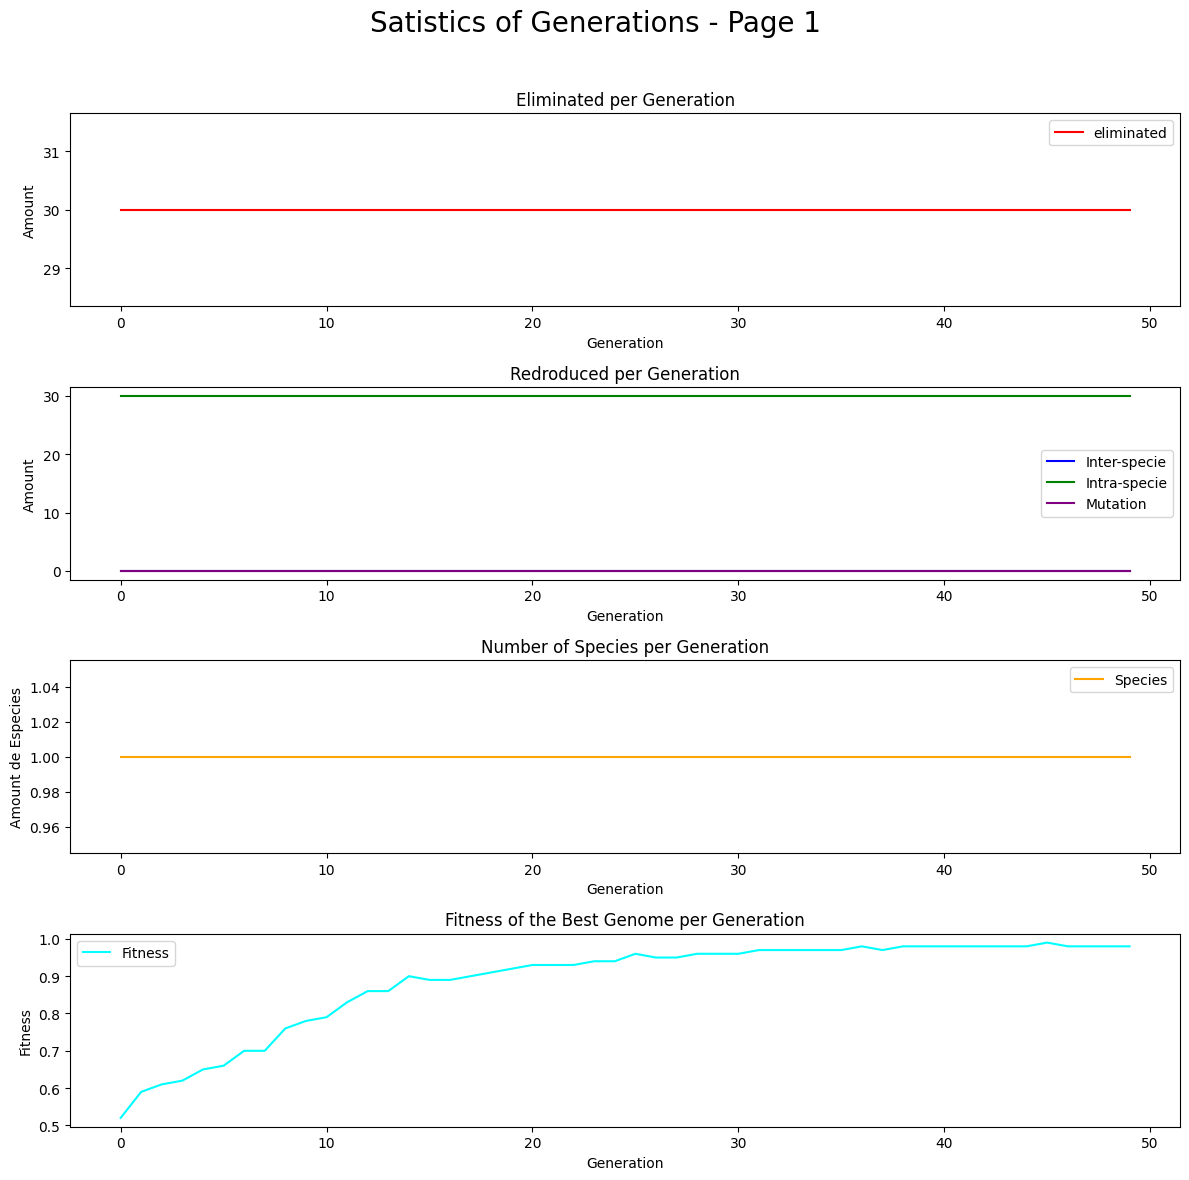

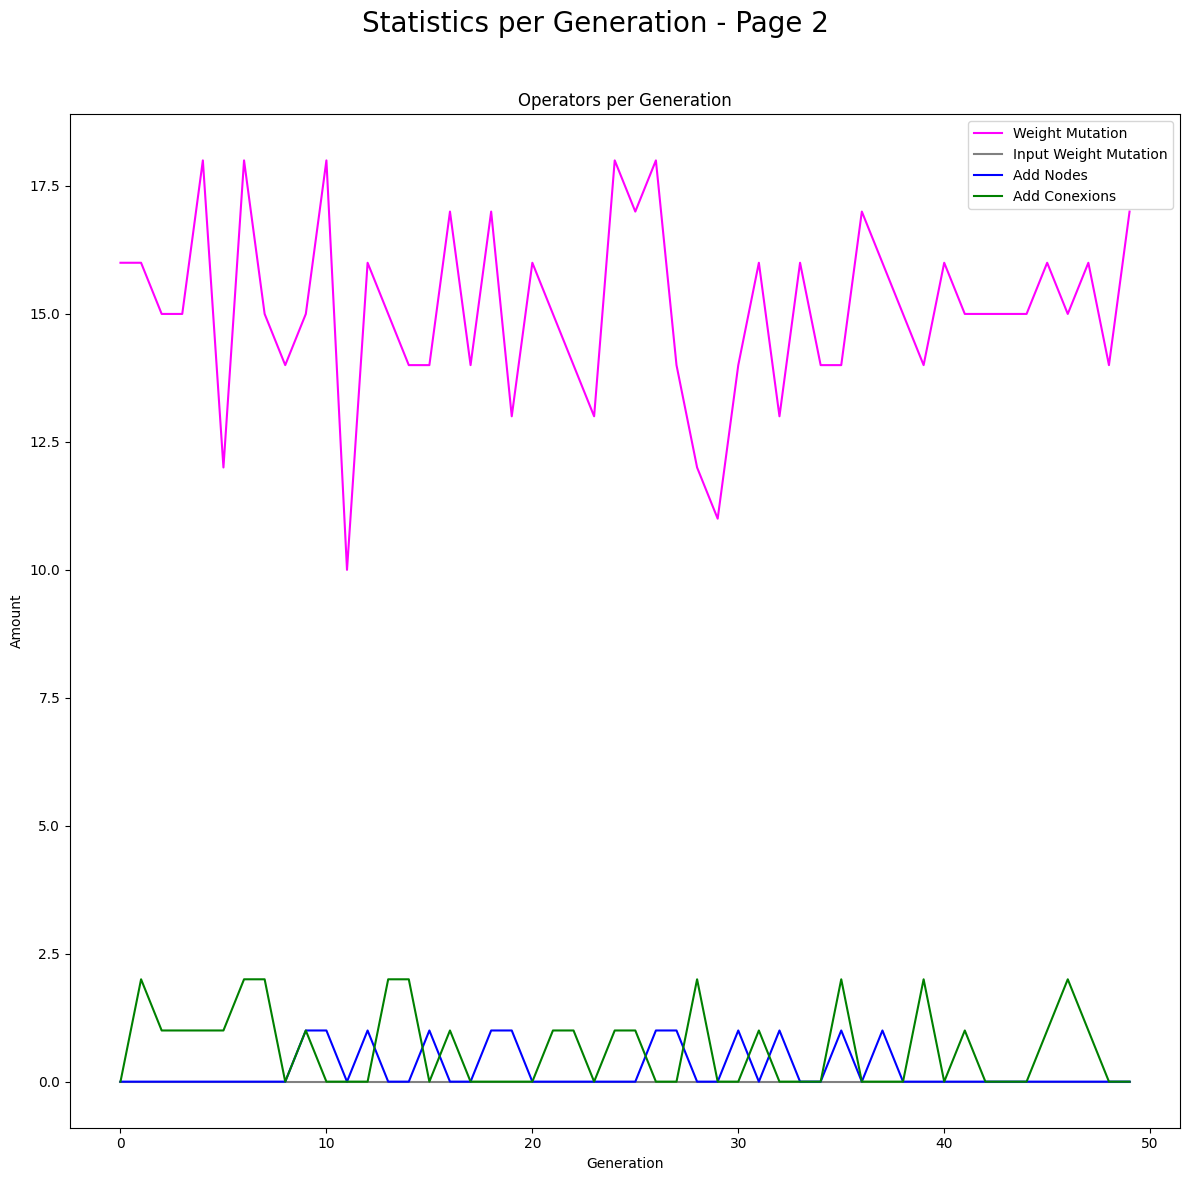

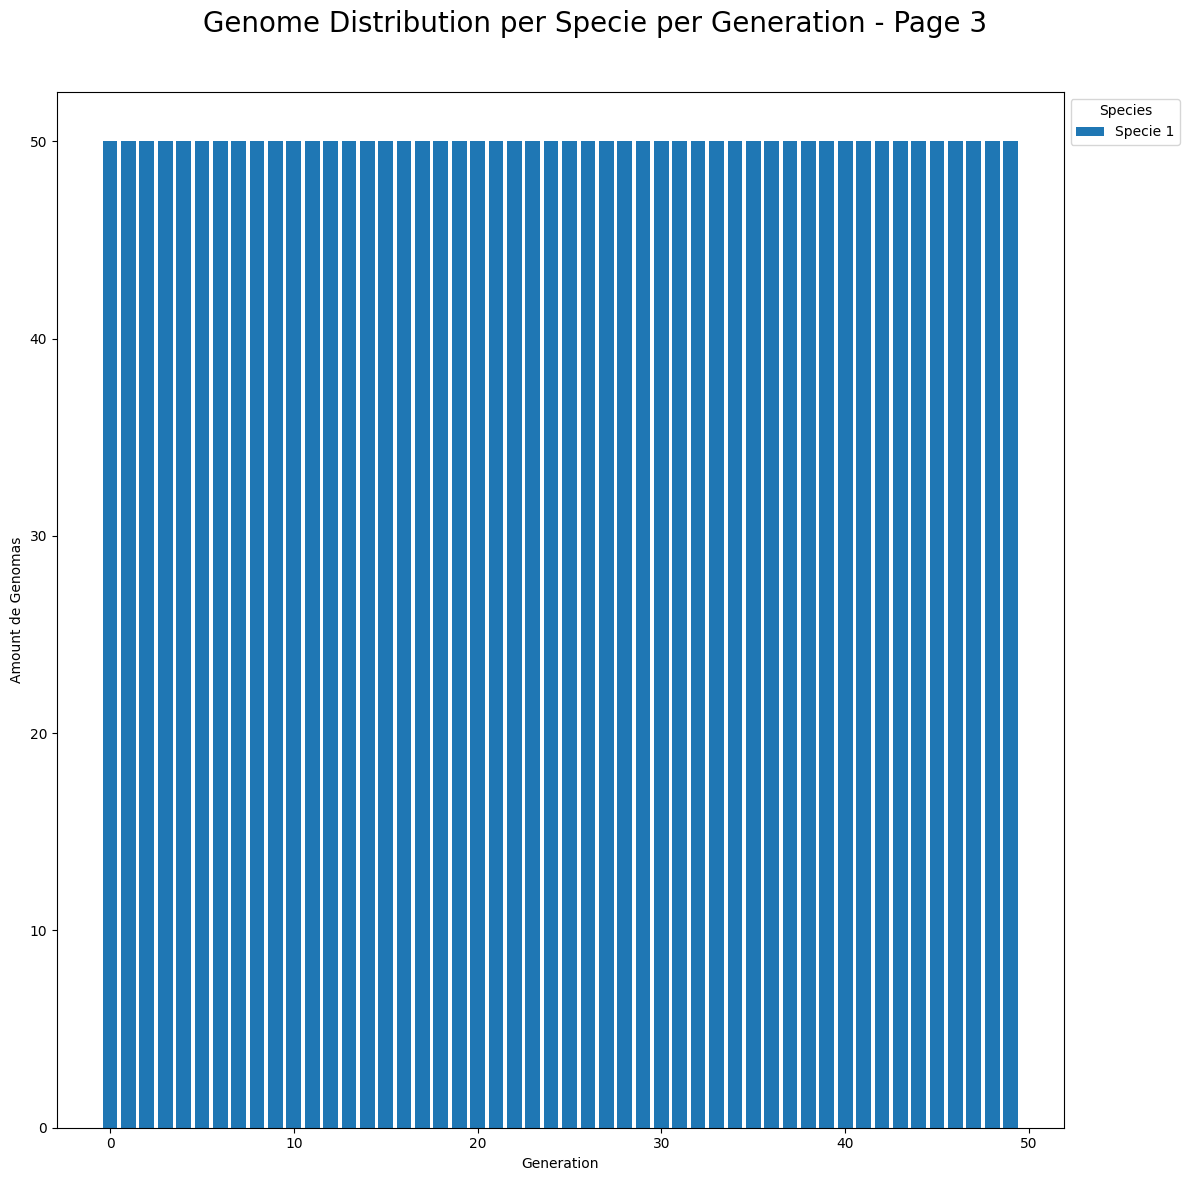

In [12]:
plot_information(trial)